# `TOC:`
* [Question-1](#Question-1)
  * [Part-(a)](#Part-(a))
  * [Part-(b)](#Part-(b))
  * [Part-(c)](#Part-(c))
  * [Part-(d)](#Part-(d))
* [Question-2](#Question-2)
  * [Part-(a)](#Part-(a))
  * [Part-(b)](#Part-(b))

Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

# Question-1

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [7]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt


def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

/home/sunild/.local/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [8]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

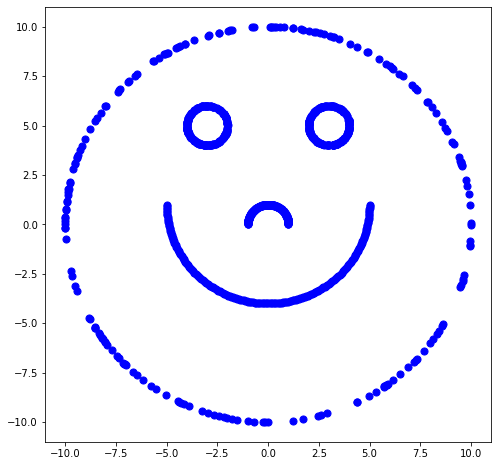

In [9]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

## Part-(a)

(a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 

#### using sklearn(K=4)

In [10]:
X.shape

(1000, 2)

In [11]:
from sklearn.cluster import KMeans

In [12]:
model=KMeans(n_clusters=4,verbose=False,init='k-means++')

In [13]:
labels=(model.fit_predict(X))

#### implementation from scratch

In [14]:
'''
func to plot 2D data with cluster IDs
Input:
data_2d: Data points in 2D :: If higher dim then can give PCA(2) applied data
labels: cluster IDs array
n_cluster: no of clusters; default = 4
Output:
plots a 2D scatter map with legend
'''
def plot_clusters(data_2d,labels,n_cluster=4):
    # filter rows of original data
    # for label in labels:
    fig = plt.figure( figsize = (8, 8) )
    plt.figure(fig.number)
    for cluster in range(n_cluster):
        label0 = data_2d[labels == cluster]
        plt.scatter(label0[:,0] , label0[:,1],label=cluster)
    plt.legend(fontsize='small')
    plt.show()

In [15]:
# to get max float point from system
import sys

In [16]:
a=np.array([[1,2],[3,4]])
np.delete(a,[0,1],axis=0)

array([], shape=(0, 2), dtype=int64)

In [17]:
np.sqrt((X-X[0,])**2)**2

array([[0.00000000e+00, 0.00000000e+00],
       [1.55277723e-08, 2.49205437e-04],
       [2.48413399e-07, 9.96573334e-04],
       ...,
       [2.58823971e+00, 3.50500230e+01],
       [5.62964147e+00, 1.65815318e+01],
       [8.85828408e+00, 2.72116678e+01]])

In [18]:
len(np.delete(X,[0,1,999],axis=0))

997

In [19]:
c=np.sum(X,axis=1)

In [20]:
np.sum(c)

1628.6156967560405

In [21]:
X.shape

(1000, 2)

In [22]:
'''
k menas clustering algo implementation
Input:
X: data points
n_cluster: no of clusters; default = 4
init_style: initial cluster choosing style; default = k-menas
    - k-means: to choose initial clusters randomly
    - k-menas++: to choose initial clusters usefully
Output:
Cluster labels for data points
''' 
def get_KMeans_clusters(X,n_cluster=4,init_style='k-means',n_iter=100):

    # to reproduce results
    # np.random.seed(1)

    n_points=X.shape[0]
    n_dim=X.shape[1]

    '''
    Get Inital Centroids
    '''
    # cluster centers are chosen to be K of the data points themselves #
    if init_style=='k-means':

        # this method simply chooses random n_cluster points from permuatated index
        init_centroids_index=rnd.permutation(n_points)[:n_cluster]
        init_centroids=X[init_centroids_index]
        # another way is to create k-many random centroids that are not data points
        #TODO: implement this one also with if-else cond
    elif init_style=='k-means++':
        # in this we choose centroids that are more representative of the sample points
        # empty array and list
        init_centroids=np.empty((n_cluster, n_dim))
        init_centroids_index=list()

        init_centroids_index.append(rnd.randint(n_points))
        init_centroids[0]=X[init_centroids_index[-1]]
       
        for i in range(1,n_cluster):
            
            # new_X=np.delete(X,init_centroids_index,axis=0)
            # no need to create a new array(2D) from X based on only unselected points
            # bcz probability for them would be zero; so they would not be selected again
             
            tmp=np.empty((n_points,i))
            for j in range(i):
                tmp[:,j]=np.sum(np.sqrt((X-init_centroids[j,:])**2),axis=1)

            tmp_min=np.min(tmp,axis=1) # min(D(X)) for each unselected point

            # convert them into probabilities
            tmp_prob=tmp_min/np.sum(tmp_min)
            # print(np.min(tmp_prob))

            # possible index values
            values=list(range(0,1000))
            # choose an index randomly based on probability
            next_centriod= np.random.choice(a=values, size=1, p=tmp_prob)[0]
            # add next centroid to the list and empty array
            init_centroids_index.append(next_centriod)
            init_centroids[i]=X[init_centroids_index[-1]]
    else:
        print('give a valid choice for init_style')
        return None
    
    '''
    KMeans Iterations
    '''
    curr_centroids=init_centroids

    # to store cluster assignment and error info after each iteration
    cluster_history=list()
    wacc_history=list()

    # for stopping/convergance criterian
    error_tol=10**(-4)
    iter_error_diff=1 
    iter_count=0
    new_objective_value=sys.float_info.max

    while (iter_error_diff>error_tol) and (iter_count<n_iter):
        # increase iter_count
        iter_count+=1
        
        # create empty temp array to store euclidean dist-sum from cluster centroids
        # do it for each cluster centroid
        tmp_array=np.empty((n_points, n_cluster))

        for cluster in range(n_cluster):
            # here distance is euclidean
            tmp_array[:,cluster]=np.sum((X-curr_centroids[cluster,:])**2,axis=1)
        
        # assign cluster to each point based on min distance from the cluster
        tmp_cluster_assign=np.argmin(tmp_array,axis=1)
        cluster_history.append(tmp_cluster_assign)
        
        # update centeroids by cluster point mean
        curr_objective_value=0
        for cluster in range(n_cluster):
            tmp_cluster_points=X[(tmp_cluster_assign==cluster),:] # 2D array
            tmp_centroid=np.mean(tmp_cluster_points,axis=0) # 1D mean array
            curr_objective_value+=np.sum(np.sum((tmp_cluster_points-tmp_centroid)**2,axis=0),axis=0) # scalar
            curr_centroids[cluster,:]=tmp_centroid # update cluster centroid
        wacc_history.append(curr_objective_value) # add curr error value to history

        # update difference
        iter_error_diff=new_objective_value-curr_objective_value
        new_objective_value=curr_objective_value
        
    # return cluster ids for each of the data points in X with some history info
    return {'final':tmp_cluster_assign,'history':cluster_history,'iter-count':iter_count,'wacc-history':wacc_history,'final-centroids':curr_centroids,'start-centroid':init_centroids_index}

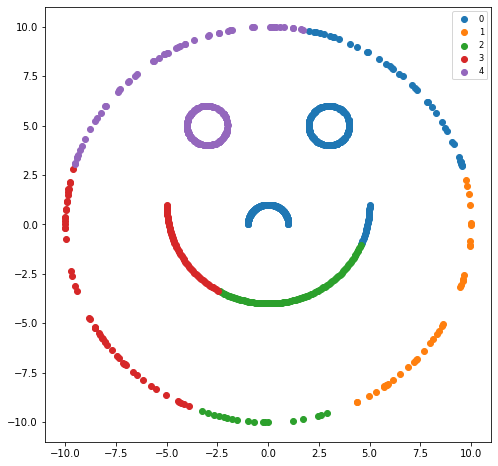

In [23]:
no_of_clusters=5
model=get_KMeans_clusters(X,n_cluster=no_of_clusters)
plot_clusters(X,model['final'],n_cluster=no_of_clusters)
# centroids=model['final-centroids']
# plt.scatter(centroids[:,0],centroids[:,1],s=300,c='red')

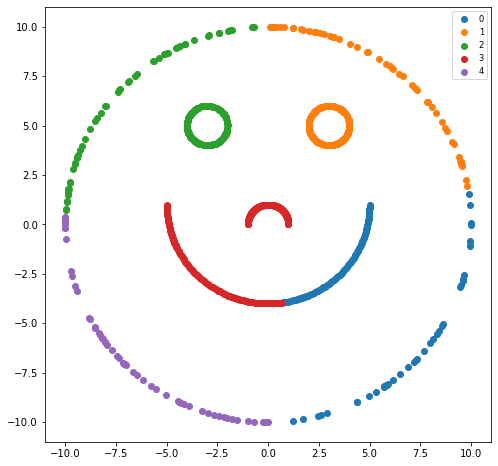

In [24]:
model=get_KMeans_clusters(X,n_cluster=no_of_clusters,init_style='k-means++')

plot_clusters(X,model['final'],n_cluster=no_of_clusters)

## Part-(b)

(b) Implement k-means++ to initialize cluster centers usefully. [5 points]

## Part-(c)

(c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]

### elbow analysis with kmeans random

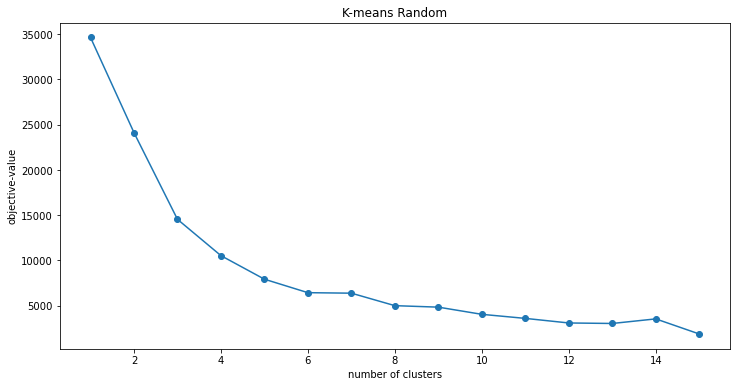

In [25]:
# fitting multiple k-means algorithms with different n_clusters and storing the values in an empty list
objective_value = []
max_cluster=15
for cluster in range(1,max_cluster+1):
    kmeans = get_KMeans_clusters(X,n_cluster=cluster)
    objective_value.append(kmeans['wacc-history'][-1])

# plotting the results
plt.figure(figsize=(12,6))
plt.plot(list(range(1,max_cluster+1)), objective_value, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('objective-value')
plt.title('K-means Random')
plt.show()

**Observations:**
- around 5-6 clusters there seems an elbow.

### elbow analysis with kmeans++

Text(0.5, 1.0, 'K-means++')

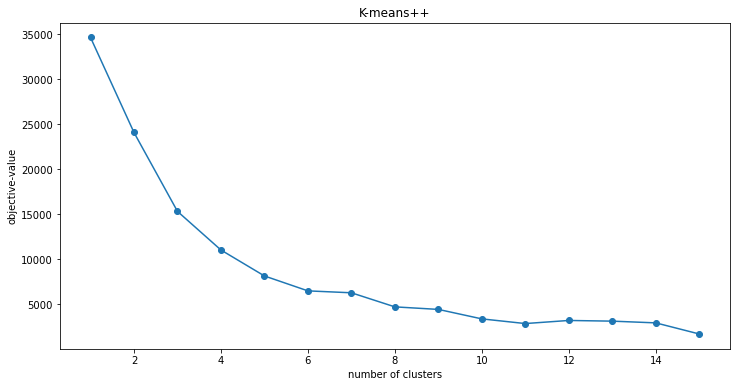

In [26]:
# fitting multiple k-means algorithms with different n_clusters and storing the values in an empty list
objective_value = []
max_cluster=15
for cluster in range(1,max_cluster+1):
    kmeans = get_KMeans_clusters(X,n_cluster=cluster,init_style='k-means++') # with kmeans++
    objective_value.append(kmeans['wacc-history'][-1])

# plotting the results
plt.figure(figsize=(12,6))
plt.plot(list(range(1,max_cluster+1)), objective_value, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('objective-value')
plt.title('K-means++')

**Observations:**
- around 5-6 clusters there seems an elbow.

### AM I HAPPY WITH THIS CLUSTERING?
- NO, I DON'T THINK SO.
- There are only linear cluster coundaries. I was hoping it would cluster `eye1`, `eye1`, `nose`, `mouth` and `face` in different clusters but that would need non-linear boundaries at least to cluster face into one cluster we will need non-linear boundary. Other items that could have been clustered with linear boundaries, that also is not being done by it.

## Part-(d)

(d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

In [ ]:
from time import time
# set this variable to change lambda in guassian kernel
LAMBDA=1
def pair_kernel_dist(x,y):
    return np.exp(-LAMBDA * np.sum((x-y)**2))
    
def pair_kernel_dist_total(x,cluster_points):
    # math is bit involving given in markdowns
    tic=time()
    n_points_=len(cluster_points)
    return_dist=n_points_**2
    for i,point1 in enumerate(cluster_points):
        for j,point2 in enumerate(cluster_points):
            if i!=j:
                return_dist+=pair_kernel_dist(point1,point2)-pair_kernel_dist(x,point1)-pair_kernel_dist(x,point2)
    toc=time()
    print(toc-tic)
    return return_dist
# def kernel_dist(X,centroid):
#     tic=time()
#     return_array=np.empty(X.shape[0])
#     for i,x in enumerate(X):
#         return_array[i]=pair_kernel_dist_total(x,centroid)
#     toc=time()
#     print(toc-tic)
#     return return_array
def kernel_dist(X,centroid):
    # exact formula is given in kernel kmeans slide 
    return 2*(1-(np.exp(-LAMBDA * np.sum((X-centroid)**2,axis=1))))

'''
k menas clustering algo implementation
Input:
X: data points
n_cluster: no of clusters; default = 4
init_style: initial cluster choosing style; default = k-menas
    - k-means: to choose initial clusters randomly
    - k-menas++: to choose initial clusters usefully
Output:
Cluster labels for data points
''' 
def get_kernel_KMeans_clusters(X,n_cluster=4,init_style='k-means',n_iter=10):

    # to reproduce results
    # np.random.seed(1)

    n_points=X.shape[0]
    n_dim=X.shape[1]
    
    '''
    Get Inital Centroids
    '''
    # cluster centers are chosen to be K of the data points themselves #
    if init_style=='k-means':

        # this method simply chooses random n_cluster points from permuatated index
        init_centroids_index=rnd.permutation(n_points)[:n_cluster]
        init_centroids=X[init_centroids_index]
        # another way is to create k-many random centroids that are not data points
        #TODO: implement this one also with if-else cond
    elif init_style=='k-means++':
        # in this we choose centroids that are more representative of the sample points
        # empty array and list
        init_centroids=np.empty((n_cluster, n_dim))
        init_centroids_index=list()

        init_centroids_index.append(rnd.randint(n_points))
        init_centroids[0]=X[init_centroids_index[-1]]
       
        for i in range(1,n_cluster):
            
            # new_X=np.delete(X,init_centroids_index,axis=0)
            # no need to create a new array(2D) from X based on only unselected points
            # bcz probability for them would be zero; so they would not be selected again
             
            tmp=np.empty((n_points,i))
            for j in range(i):
                #TODO:done
                tmp[:,j]=np.sqrt(kernel_dist(X,init_centroids[j,:]))

            tmp_min=np.min(tmp,axis=1) # min(D(X)) for each unselected point

            # convert them into probabilities
            tmp_prob=tmp_min/np.sum(tmp_min)
            # print(np.min(tmp_prob))

            # possible index values
            values=list(range(0,1000))
            # choose an index randomly based on probability
            next_centriod= np.random.choice(a=values, size=1, p=tmp_prob)[0]
            # add next centroid to the list and empty array
            init_centroids_index.append(next_centriod)
            init_centroids[i]=X[init_centroids_index[-1]]
    else:
        print('give a valid choice for init_style')
        return None
    
    '''
    KMeans Iterations
    '''
    # curr_centroids=list()
    # for i in range(n_cluster):
    #     curr_centroids.append(init_centroids[i,])
    curr_centroids=init_centroids

    # to store cluster assignment and error info after each iteration
    cluster_history=list()
    wacc_history=list()

    # for stopping/convergance criterian
    error_tol=10**(-4)
    iter_error_diff=1 
    iter_count=0
    new_objective_value=sys.float_info.max

    while (iter_error_diff>error_tol) and (iter_count<n_iter):
        # increase iter_count
        iter_count+=1
        
        # create empty temp array to store euclidean dist-sum from cluster centroids
        # do it for each cluster centroid
        tmp_array=np.empty((n_points, n_cluster))

        for cluster in range(n_cluster):
            # here distance is euclidean
            #TODO:done
            tmp_array[:,cluster]=kernel_dist(X,curr_centroids[cluster,:])
        # print(tmp_cluster_assign)
        # assign cluster to each point based on min distance from the cluster
        tmp_cluster_assign=np.argmin(tmp_array,axis=1)
        cluster_history.append(tmp_cluster_assign)
        # print(tmp_cluster_assign)
        # update centeroids by cluster point mean
        curr_objective_value=0
        for cluster in range(n_cluster):
            tmp_cluster_points=X[(tmp_cluster_assign==cluster),:] # 2D array
            #TODO:??
            tmp_centroid=np.mean(tmp_cluster_points,axis=0) # 1D mean array
            #TODO:done:done
            # print(tmp_cluster_points)
            curr_objective_value+=np.sum(kernel_dist(tmp_cluster_points,tmp_cluster_points)) # scalar
            curr_centroids[cluster,]=tmp_centroid # update cluster centroid
        # print(curr_centroids)
        wacc_history.append(curr_objective_value) # add curr error value to history

        # update difference
        iter_error_diff=new_objective_value-curr_objective_value
        new_objective_value=curr_objective_value
    return tmp_cluster_assign
    # return cluster ids for each of the data points in X with some history info
    # return {'final':tmp_cluster_assign,'history':cluster_history,'iter-count':iter_count,}#'wacc-history':wacc_history,'final-centroids':curr_centroids,'start-centroid':init_centroids_index}

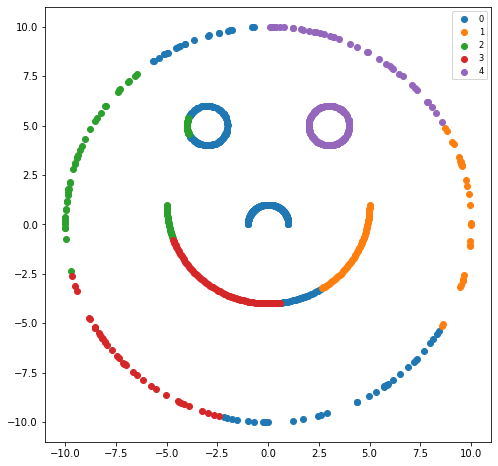

In [42]:
plot_clusters(X,get_kernel_KMeans_clusters(X,n_iter=1000,n_cluster=5,init_style="k-means++"),n_cluster=5)

- the below one is painfully slow; Time complexity for each update iteration: $\mathcal{O}(KN^3)$

In [54]:
from time import time
# set this variable to change lambda in guassian kernel
LAMBDA=1
def pair_kernel_dist(x,y):
    return np.exp(-LAMBDA * np.sum((x-y)**2))
    
def pair_kernel_dist_total(x,cluster_points):
    # math is bit involving given in markdowns
    # tic=time()
    n_points_=len(cluster_points)
    return_dist=0
    for i,point1 in enumerate(cluster_points):
        return_dist-=(2/n_points_)*pair_kernel_dist(x,point1)
        
    # toc=time()
    # print(toc-tic)
    return return_dist
def kernel_dist(X,centroid):
    tic=time()
    n_points_=len(centroid)
    centroid_points_dist=n_points_
    for i in range(n_points_):
        for j in range(n_points_):
            # this one is 2 times faster than the below one
            if j>i:
                centroid_points_dist+=2*pair_kernel_dist(centroid[i,],centroid[j,])
            # below one is inefficient
            # if i!=j:
            #     centroid_points_dist+=pair_kernel_dist(centroid[i,],centroid[j,])
    centroid_points_dist=centroid_points_dist/(n_points_**2)
    toc=time()
    print(toc-tic)
    
    return_array=np.empty(X.shape[0])
    for i,x in enumerate(X):
        return_array[i]=pair_kernel_dist_total(x,centroid)+centroid_points_dist
    
    return return_array
def k(X,centroid):
    # exact formula is given in kernel kmeans slide 
    return 2*(1-(np.exp(-LAMBDA * np.sum((X-centroid)**2,axis=1))))

'''
k menas clustering algo implementation
Input:
X: data points
n_cluster: no of clusters; default = 4
init_style: initial cluster choosing style; default = k-menas
    - k-means: to choose initial clusters randomly
    - k-menas++: to choose initial clusters usefully
Output:
Cluster labels for data points
''' 
def get_kernel_KMeans_clusters(X,n_cluster=4,init_style='k-means',n_iter=2):

    # to reproduce results
    # np.random.seed(1)

    n_points=X.shape[0]
    n_dim=X.shape[1]

    '''
    Get Inital Centroids
    '''
    # cluster centers are chosen to be K of the data points themselves #
    if init_style=='k-means':

        # this method simply chooses random n_cluster points from permuatated index
        init_centroids_index=rnd.permutation(n_points)[:n_cluster]
        init_centroids=X[init_centroids_index]
        # another way is to create k-many random centroids that are not data points
        #TODO: implement this one also with if-else cond
    elif init_style=='k-means++':
        # in this we choose centroids that are more representative of the sample points
        # empty array and list
        init_centroids=np.empty((n_cluster, n_dim))
        init_centroids_index=list()

        init_centroids_index.append(rnd.randint(n_points))
        init_centroids[0]=X[init_centroids_index[-1]]
       
        for i in range(1,n_cluster):
            
            # new_X=np.delete(X,init_centroids_index,axis=0)
            # no need to create a new array(2D) from X based on only unselected points
            # bcz probability for them would be zero; so they would not be selected again
             
            tmp=np.empty((n_points,i))
            for j in range(i):
                #TODO:done
                # tmp[:,j]=np.sqrt(kernel_dist(X,init_centroids[j,:]))
                tmp[:,j]=np.sqrt(k(X,init_centroids[j,:]))

            tmp_min=np.min(tmp,axis=1) # min(D(X)) for each unselected point

            # convert them into probabilities
            tmp_prob=tmp_min/np.sum(tmp_min)
            print(np.sum(tmp_min))

            # possible index values
            values=list(range(0,1000))
            # choose an index randomly based on probability
            next_centriod= np.random.choice(a=values, size=1, p=tmp_prob)[0]
            # add next centroid to the list and empty array
            init_centroids_index.append(next_centriod)
            init_centroids[i]=X[init_centroids_index[-1]]
    else:
        print('give a valid choice for init_style')
        return None
    
    '''
    KMeans Iterations
    '''
    curr_centroids=list()
    for i in range(n_cluster):
        curr_centroids.append(init_centroids[i,])

    # to store cluster assignment and error info after each iteration
    cluster_history=list()
    wacc_history=list()

    # for stopping/convergance criterian
    error_tol=10**(-4)
    iter_error_diff=1 
    iter_count=0
    new_objective_value=sys.float_info.max

    while iter_count<n_iter:
        # increase iter_count
        iter_count+=1
        
        # create empty temp array to store euclidean dist-sum from cluster centroids
        # do it for each cluster centroid
        tmp_array=np.empty((n_points, n_cluster))

        for cluster in range(n_cluster):
            # here distance is euclidean
            #TODO:done
            tmp_array[:,cluster]=kernel_dist(X,curr_centroids[cluster])
        # print(tmp_cluster_assign)
        # assign cluster to each point based on min distance from the cluster
        tmp_cluster_assign=np.argmin(tmp_array,axis=1)
        cluster_history.append(tmp_cluster_assign)
        # print(tmp_cluster_assign)
        # update centeroids by cluster point mean
        curr_objective_value=0
        for cluster in range(n_cluster):
            tmp_cluster_points=X[(tmp_cluster_assign==cluster),:] # 2D array
            #TODO:??
            # tmp_centroid=np.mean(tmp_cluster_points,axis=0) # 1D mean array
            #TODO:done:done
            # print(tmp_cluster_points)
            # curr_objective_value+=np.sum(kernel_dist(tmp_cluster_points,tmp_cluster_points)) # scalar
            curr_centroids[cluster]=tmp_cluster_points # update cluster centroid
        # print(curr_centroids)
        wacc_history.append(curr_objective_value) # add curr error value to history

        # update difference
        # iter_error_diff=new_objective_value-curr_objective_value
        # new_objective_value=curr_objective_value
    return tmp_cluster_assign
    # return cluster ids for each of the data points in X with some history info
    # return {'final':tmp_cluster_assign,'history':cluster_history,'iter-count':iter_count,}#'wacc-history':wacc_history,'final-centroids':curr_centroids,'start-centroid':init_centroids_index}a

1310.1951977607594
1250.2322989906093
1227.6457885109626
1162.5256462788802
4.5299530029296875e-05
3.790855407714844e-05
6.222724914550781e-05
4.9114227294921875e-05
4.291534423828125e-05
0.051276206970214844
0.011703014373779297
0.16782903671264648
1.1432936191558838
0.0316157341003418
0.04294180870056152
0.0175933837890625
0.1616358757019043
1.0846831798553467
0.034622907638549805
0.04260993003845215
0.02305316925048828
0.1274125576019287
1.0430667400360107
0.0337824821472168
0.047130584716796875
0.03235626220703125
0.1363694667816162
1.4149119853973389
0.03446626663208008
0.03778791427612305
0.03320121765136719
0.0847327709197998
1.1284217834472656
0.03494119644165039
0.03680086135864258
0.038587331771850586
0.087158203125
1.2322406768798828
0.03775143623352051
0.039763689041137695
0.04053831100463867
0.07183337211608887
1.317903995513916
0.03619074821472168
0.03729653358459473
0.038121938705444336
0.053510189056396484
1.2445721626281738
0.035677433013916016
0.03700590133666992
0.03

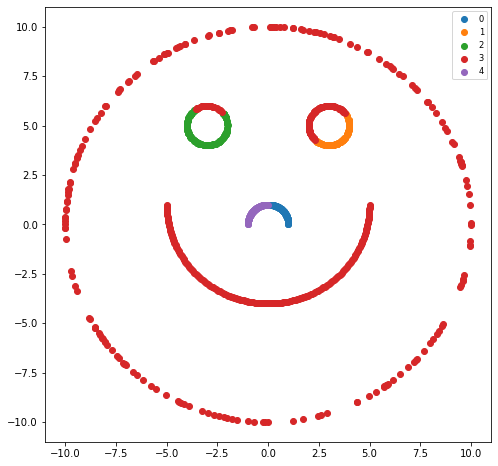

In [56]:
plot_clusters(X,get_kernel_KMeans_clusters(X,n_cluster=5,n_iter=20,init_style='k-means++'),n_cluster=5)

- it is too slow; have to use other techniques that might work faster; basically transfer data into hilbert space and use k-means clustering

# Question-2

### Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

## Part-(a)

(a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

## Part-(b)

(b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 